In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import numpy as np
import random
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import seaborn as sns
# from ucimlrepo import fetch_ucirepo 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

from data.data_loader import PowerConsumptionDataset
from models.lstm import LSTMModel
from models.lstm_attention import LSTMWithAttention
from models.gru import GRUModel
from models.utils import create_model, train_and_evaluate, load_model
from explainers.lime import LimeExplainer
from explainers.shap import ShapExplainer
from explainers.attention import AttentionExplainer
from explainers.grad_cam import GradCAMExplainer
from explainers.lrp import LRPExplainer

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# 'LSTM' or 'GRU' for LIME and SHAP, 'LSTM_Attention' for 'Attention' 
model_name = 'LSTM'  
model_name_attention = 'LSTM_Attention'  
hidden_size = 50
num_layers = 2
output_size = 1
dropout = 0.2
num_epochs = 50
batch_size = 64
learning_rate = 0.001
sequence_length = 60  # e.g., past 60 minutes
feature_idx = [0,1,2,3,4,5,6]
# feature_idx = []
if len(feature_idx) == 0: num_of_features = 7
else: num_of_features = len(feature_idx)
input_size = num_of_features  # Number of total features in the dataset

model_path = ('./trained_models/{}_features_' + '_'.join(['{}'] * len(feature_idx)) + '.pth').format(model_name, *feature_idx)
model_attention_path = ('./trained_models/{}_features_' + '_'.join(['{}'] * len(feature_idx)) + '.pth').format(model_name_attention, *feature_idx)

lime_path = './trained_explainer/lime_explainer_config.json'

In [4]:
dataset = PowerConsumptionDataset(file_path='data/household_power_consumption.txt',
                                  feature_idx = feature_idx,
                                  num_of_features=num_of_features)
train_sequences, eval_sequences, train_targets, eval_targets = dataset.load_data()

/archive/workspace/XAI/co-work/data/data_loader.py:23: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(self.file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/archive/workspace/XAI/co-work/data/data_loader.py:23: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(self.file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/archive/workspace/XAI/co-work/data/data_loader.py:23: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(self.file_path, sep=';', parse_dates

In [5]:
model = create_model(model_name, input_size, hidden_size, num_layers, output_size, dropout)

# Check if the model already exists
if os.path.exists(model_path):
    print(f"Loading the pre-trained {model_name} model...")
    model = load_model(model, model_path)
    model.to(device)
else:
    print(f"Training a new {model_name} model...")
    train_and_evaluate(model, train_sequences, train_targets, 
                       eval_sequences, eval_targets, model_path,
                       num_epochs, batch_size, learning_rate)

Loading the pre-trained LSTM model...


In [6]:
model_attention = create_model(model_name_attention, input_size, hidden_size, num_layers, output_size, dropout)

# Check if the model already exists
if os.path.exists(model_attention_path):
    print(f"Loading the pre-trained {model_name_attention} model...")
    model_attention = load_model(model_attention, model_attention_path)
    model_attention.to(device)
else:
    print(f"Training a new {model_name_attention} model...")
    train_and_evaluate(model_attention, train_sequences, train_targets, 
                       eval_sequences, eval_targets, model_attention_path,
                       num_epochs, batch_size, learning_rate)

Epoch 19/50:  12%|███▋                          | 3208/25940 [00:08<01:01, 369.02batch/s, loss=0.000268]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 21/50:   2%|▋                              | 594/25940 [00:01<01:10, 361.79batch/s, loss=0.000374]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 21/50:  12%|███▍                          | 3008/25940 [00:08<01:01, 374.06batch/s, loss=0.000813]IOPub message rate exceeded.
The Jupyter server will

Epoch [26/50], Train Loss: 0.0004, Val Loss: 0.0004


Epoch 28/50:  13%|███▊                          | 3328/25940 [00:09<01:03, 355.61batch/s, loss=0.000377]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Explain

### LIME

In [8]:
explainer_type = 'LIME'  # or 'SHAP'

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, train_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, device, train_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

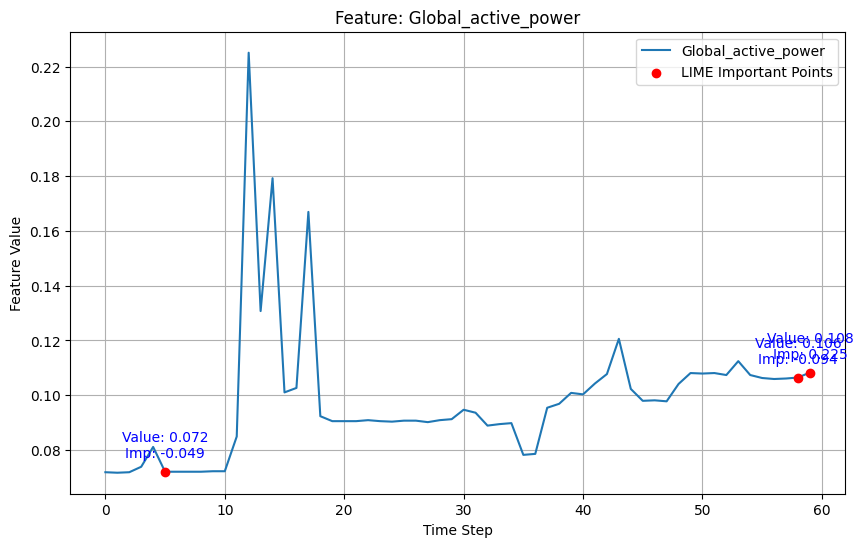


Feature: Global_active_power - Detailed Information
Time Step: 59, Feature Value: 0.108, Importance: 0.225
Time Step: 58, Feature Value: 0.106, Importance: -0.094
Time Step: 5, Feature Value: 0.072, Importance: -0.049


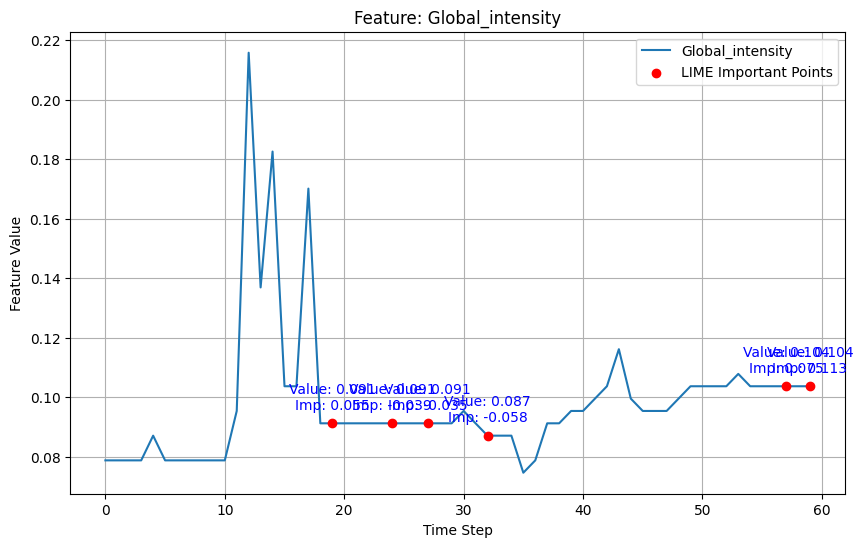


Feature: Global_intensity - Detailed Information
Time Step: 59, Feature Value: 0.104, Importance: 0.113
Time Step: 57, Feature Value: 0.104, Importance: 0.075
Time Step: 32, Feature Value: 0.087, Importance: -0.058
Time Step: 19, Feature Value: 0.091, Importance: 0.055
Time Step: 24, Feature Value: 0.091, Importance: -0.039
Time Step: 27, Feature Value: 0.091, Importance: -0.035


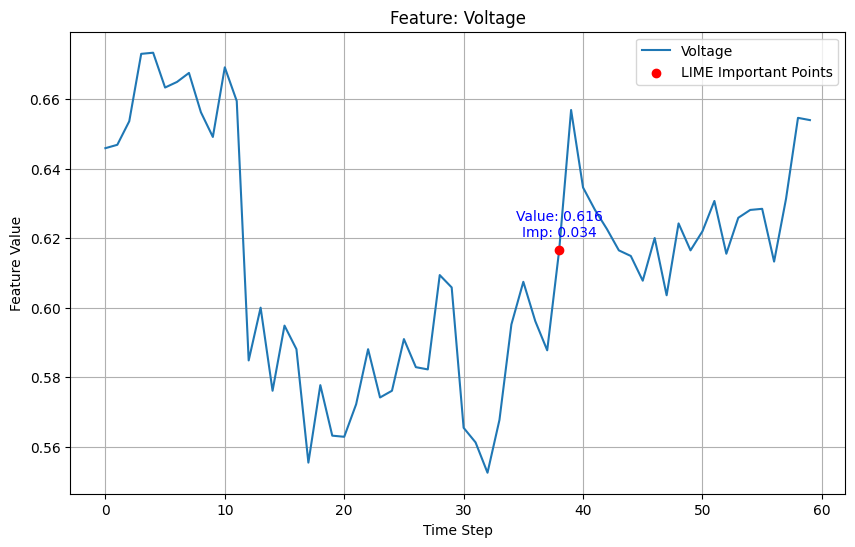


Feature: Voltage - Detailed Information
Time Step: 38, Feature Value: 0.616, Importance: 0.034


In [9]:
# Explain a specific data point
explanation = explainer.explain(train_sequences[1])

### SHAP

In [18]:
explainer_type = 'SHAP' 

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, train_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, train_sequences, sequence_length, 
                              input_size, dataset.selected_features, device)

else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

#### For one sample

  0%|          | 0/1 [00:00<?, ?it/s]

Summary plot


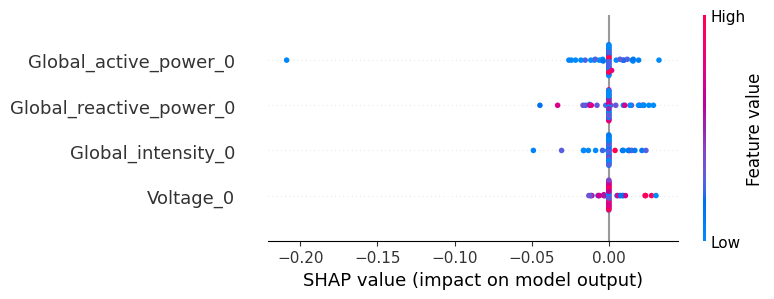

Force plot


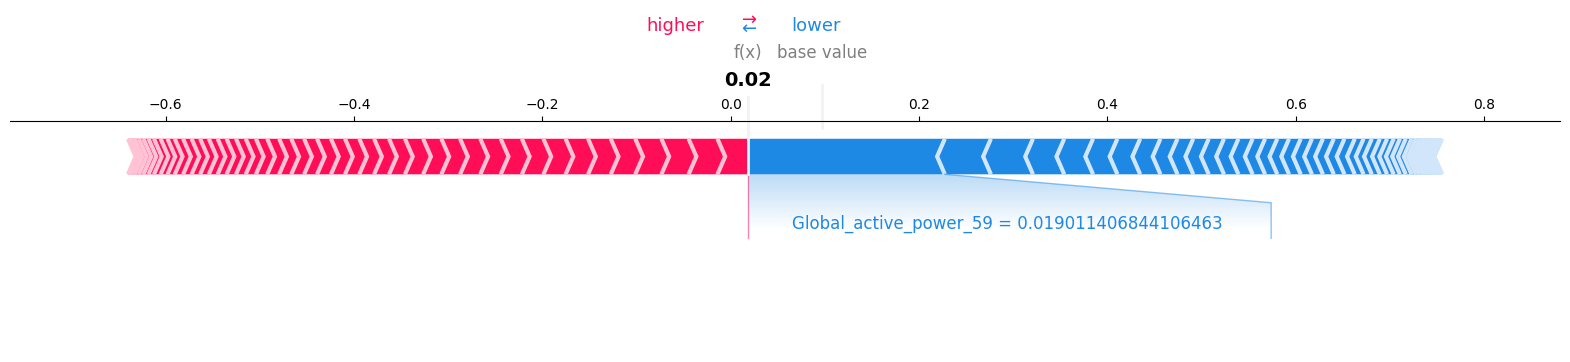

Waterfall plot


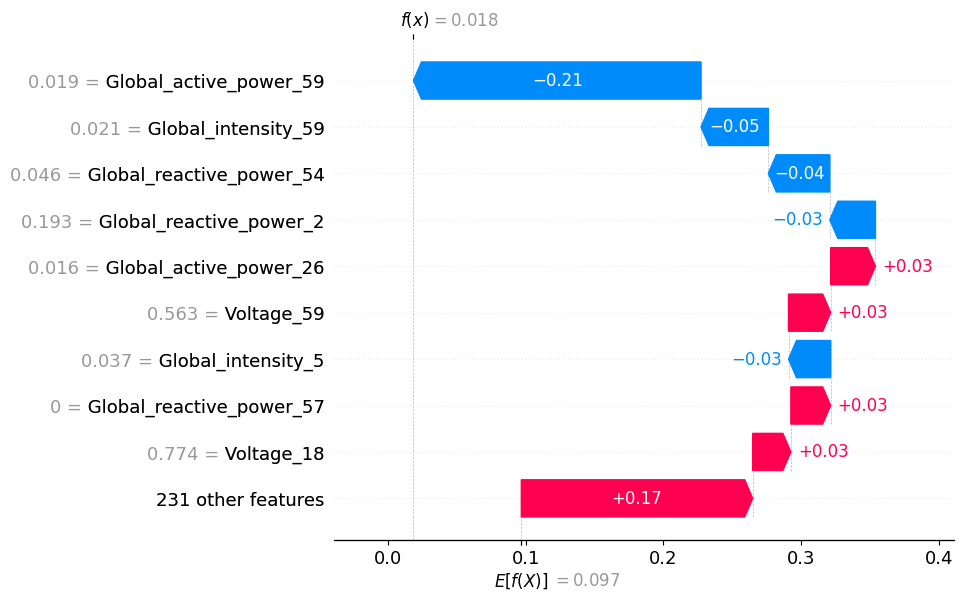

Dependence plot


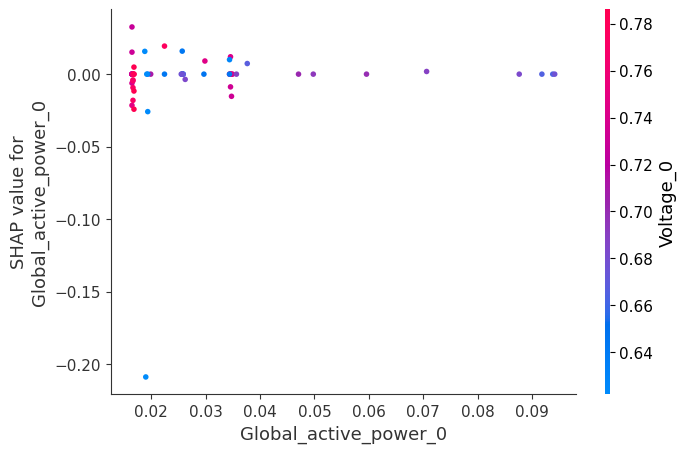

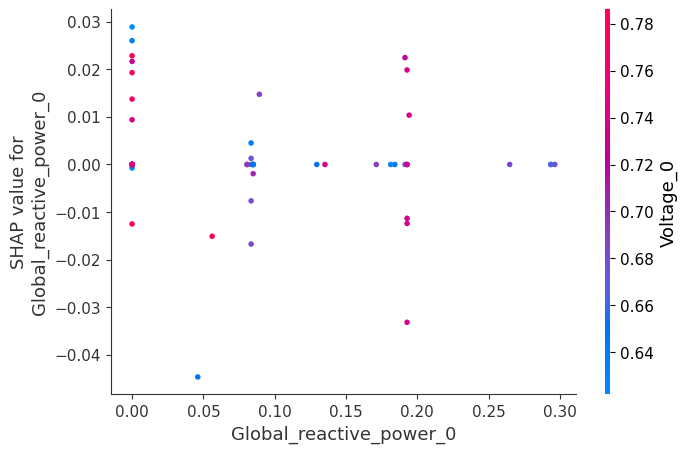

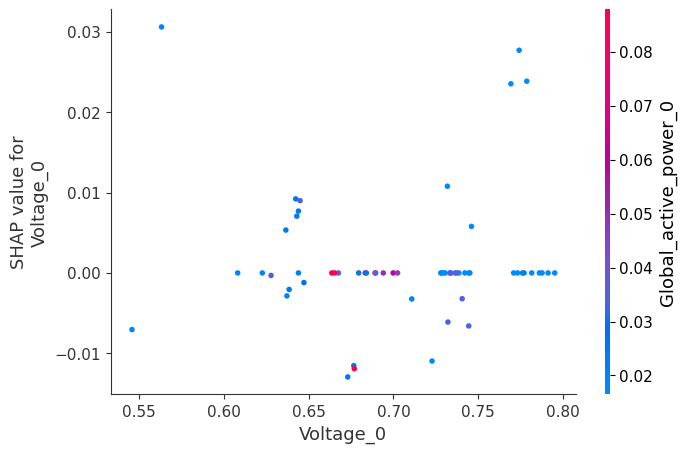

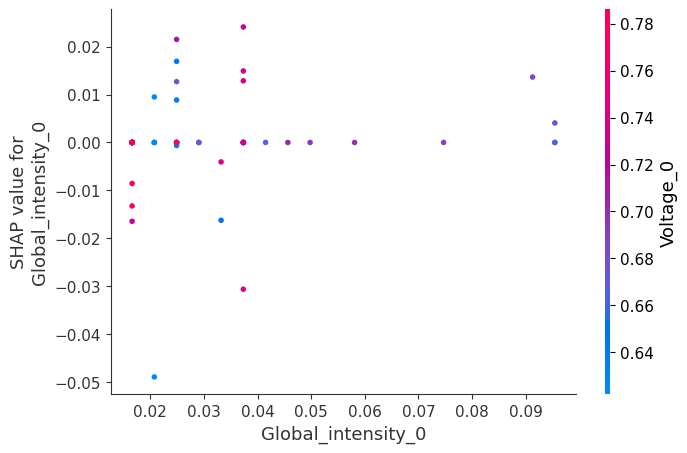

Decision plot


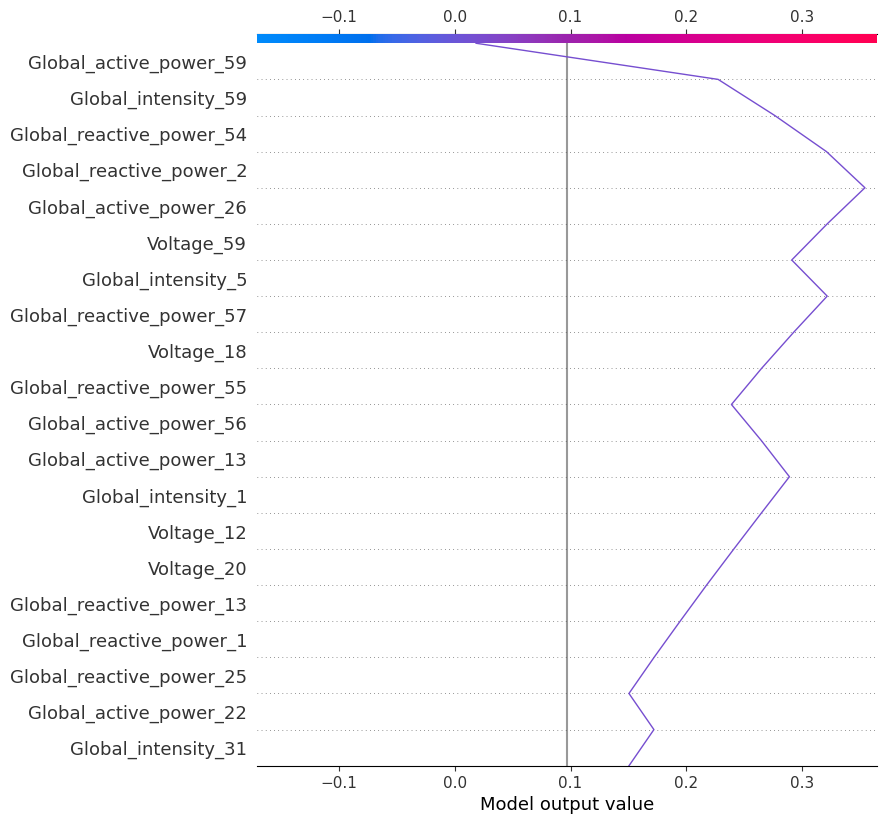

Scatter plot


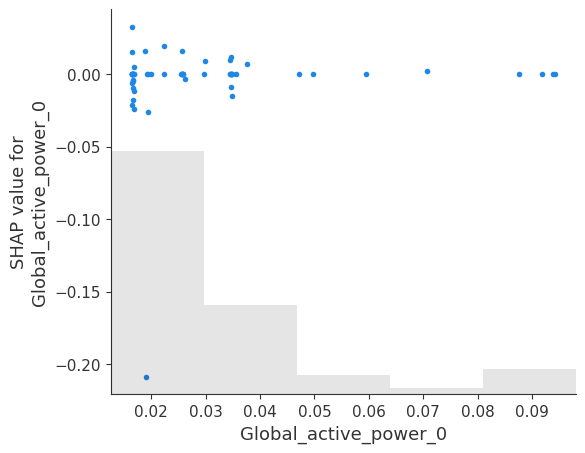

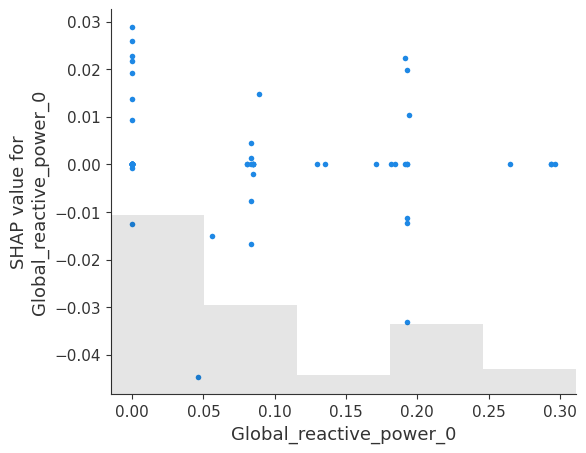

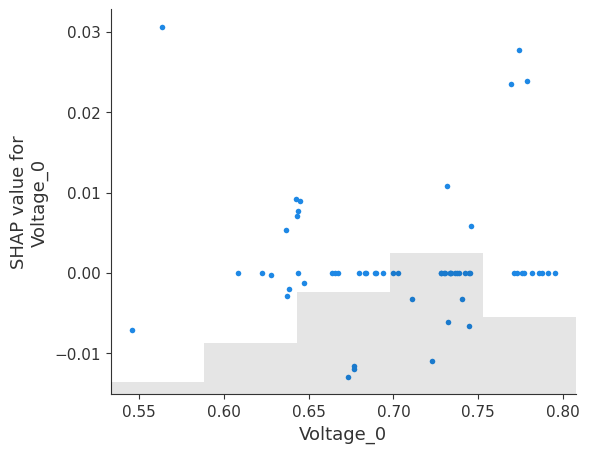

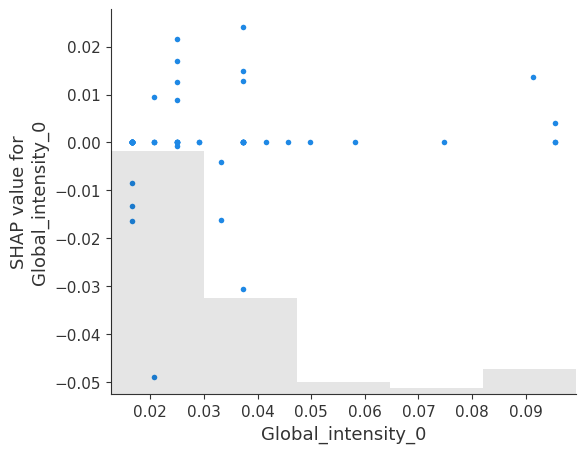

Bar plot


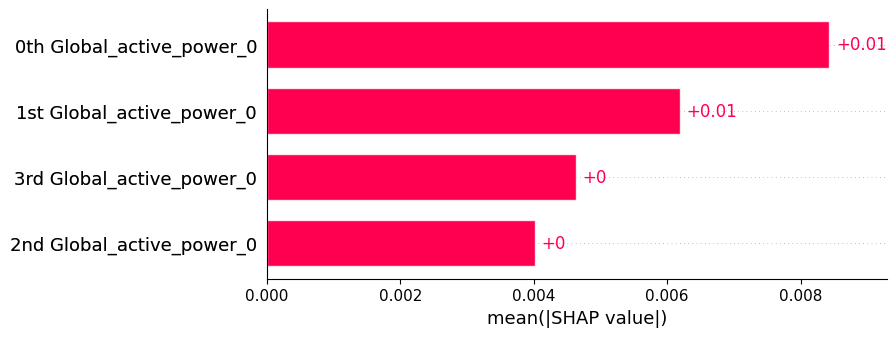

Beaswarm plot


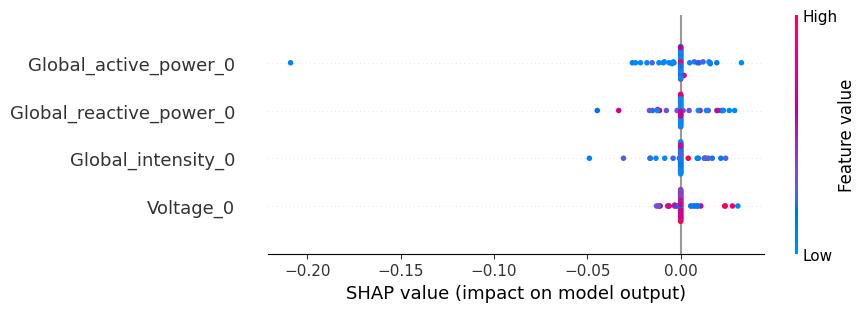

Heatamp plot


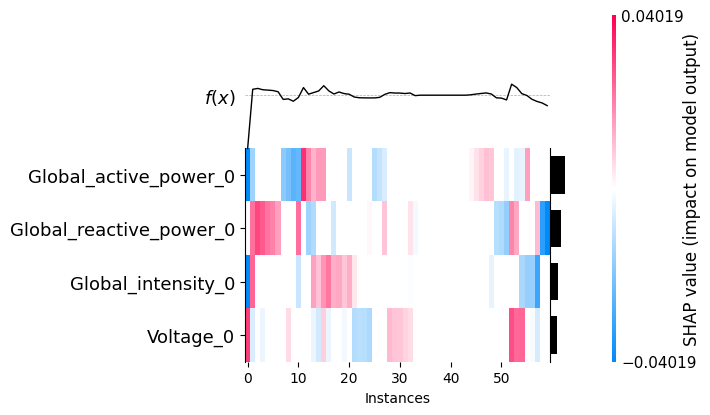

Partial dependence plot
Feature Global_active_power not found in sample_df columns: Index(['Global_active_power_0', 'Global_reactive_power_0', 'Voltage_0',
       'Global_intensity_0'],
      dtype='object')


In [7]:
num_samples = 1  
shap_values, sampled_eval_sequences = explainer.explain(eval_sequences,
                                                        num_samples=num_samples)

explainer.visualize_all_one_sample(shap_values, sampled_eval_sequences)

#### For multiple samples

  0%|          | 0/10 [00:00<?, ?it/s]

Summary plot


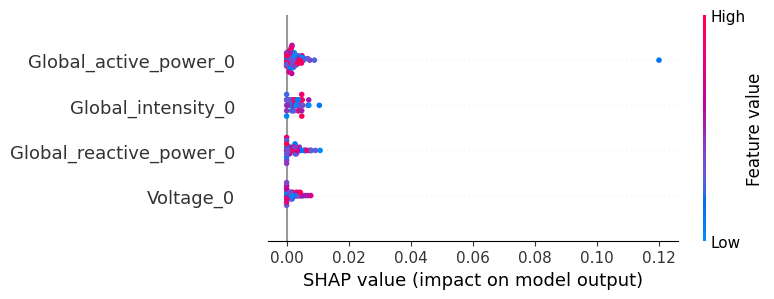

Force plot


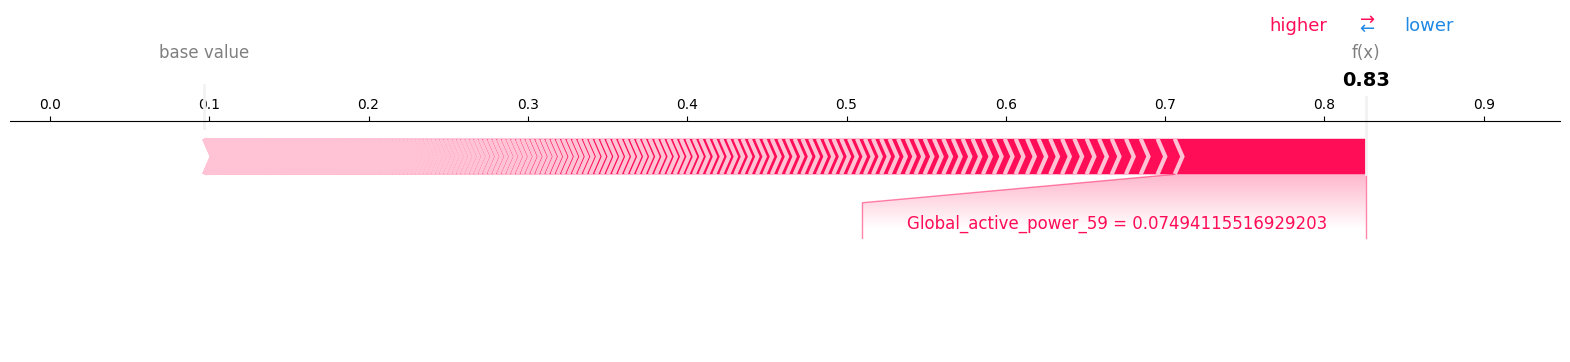

Waterfall plot


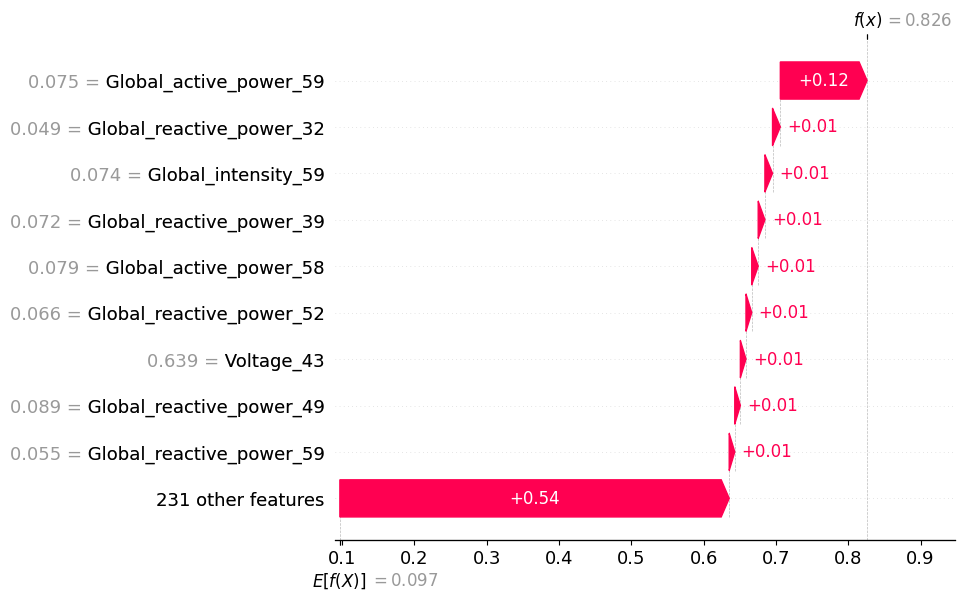

Dependence plot


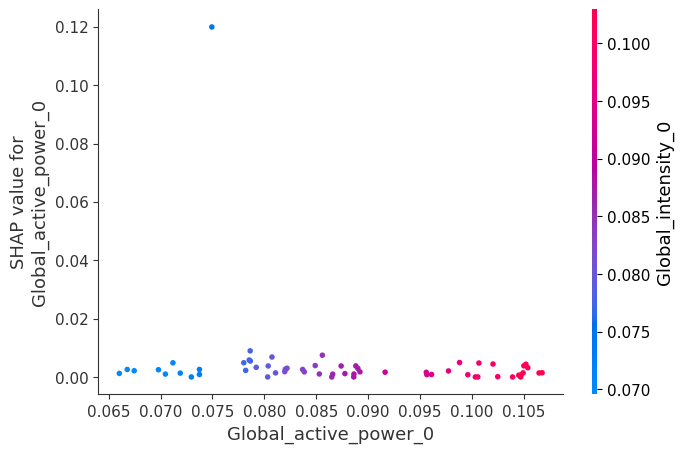

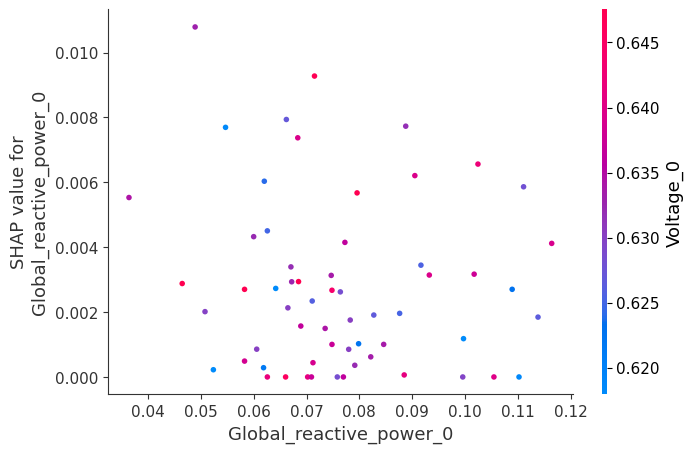

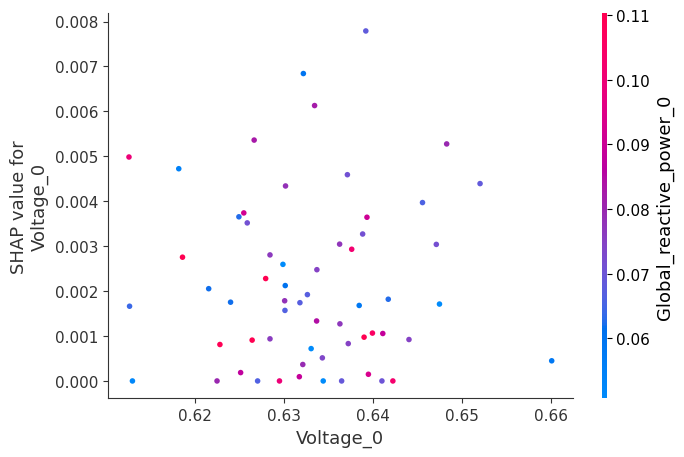

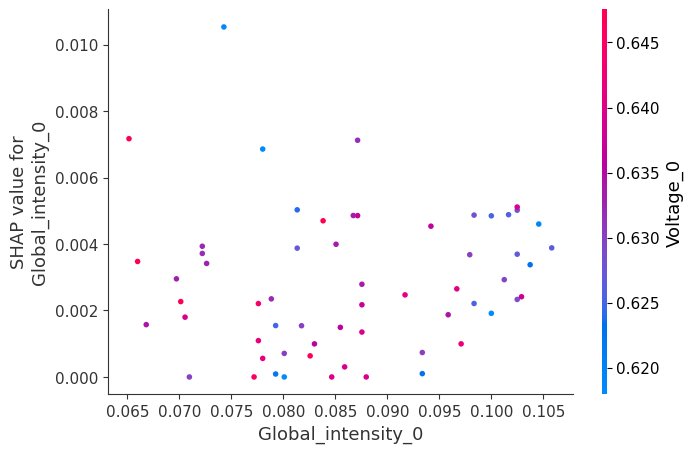

Decision plot


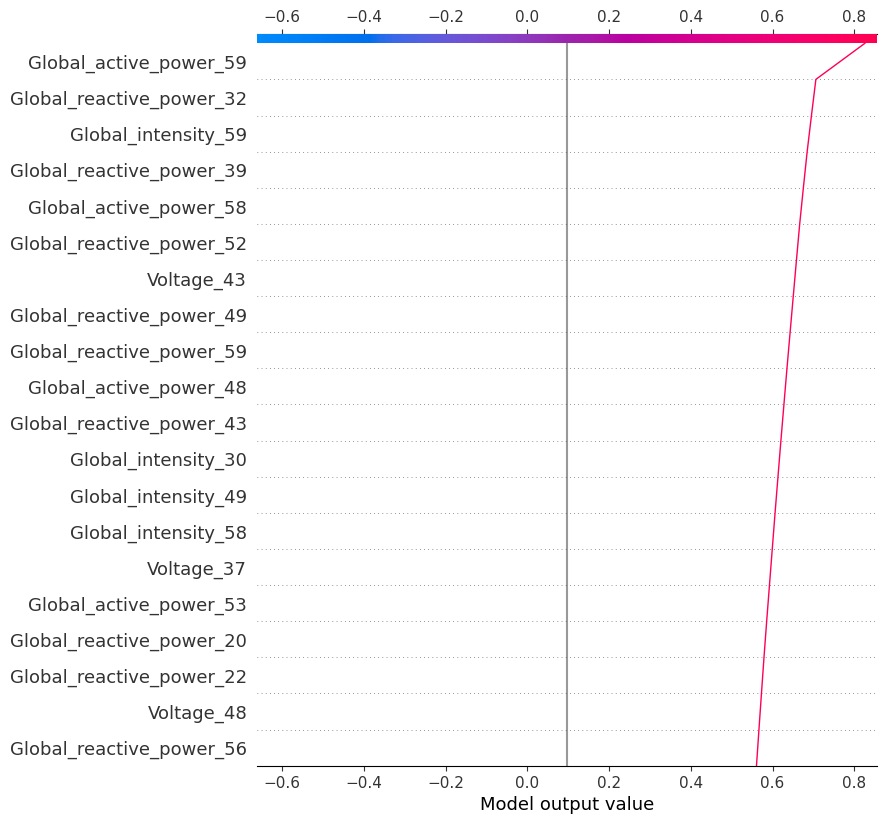

Scatter plot


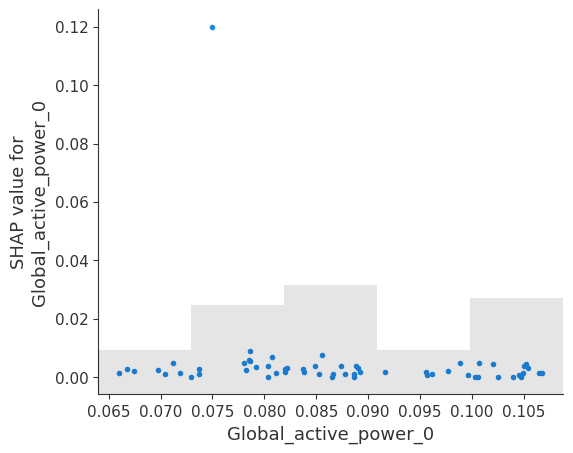

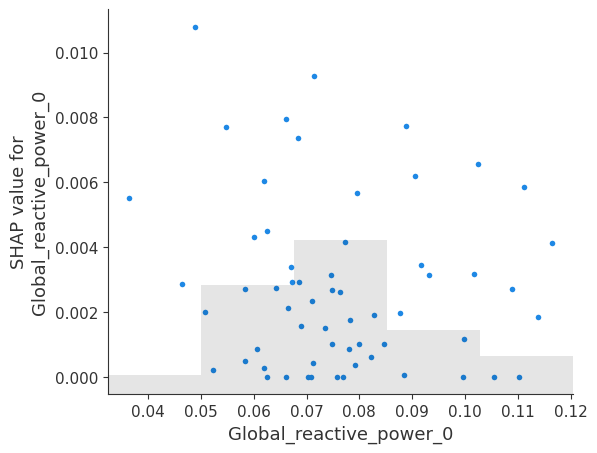

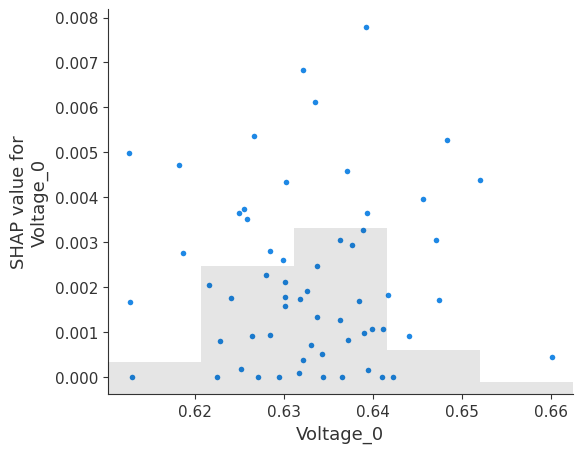

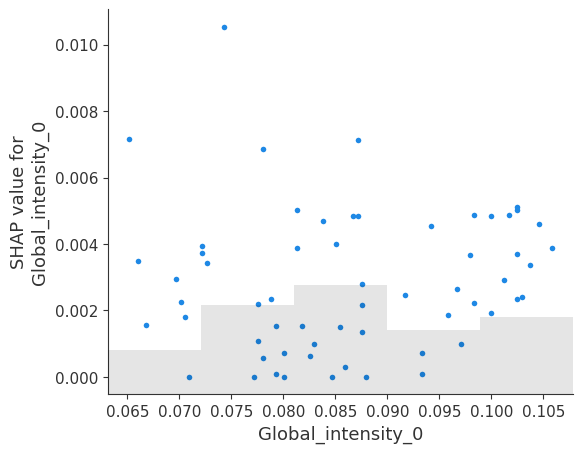

Bar plot


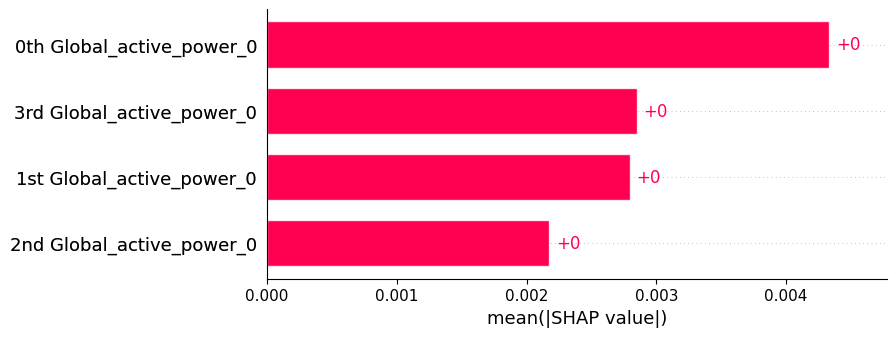

Beaswarm plot


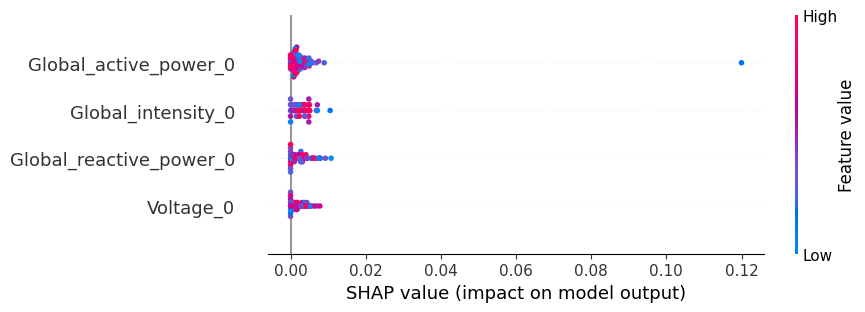

Heatamp plot


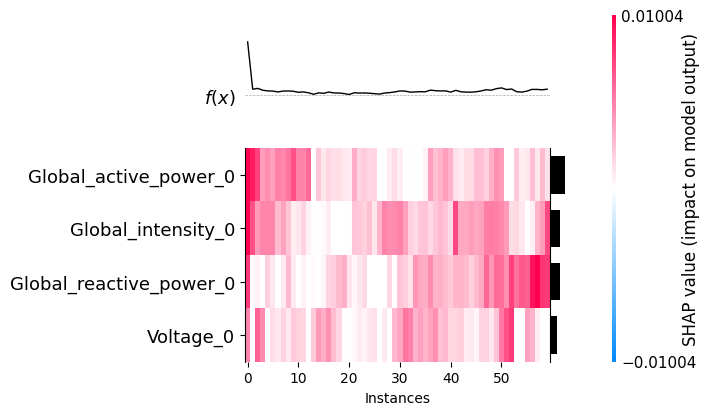

Partial dependence plot
Feature Global_active_power not found in sample_df columns: Index(['Global_active_power_0', 'Global_reactive_power_0', 'Voltage_0',
       'Global_intensity_0'],
      dtype='object')


In [10]:
num_samples = 10  # 다수 샘플 사용
shap_values, sampled_eval_sequences = explainer.explain(eval_sequences, num_samples=num_samples)

explainer.visualize_all_multiple_samples(shap_values, sampled_eval_sequences)

### Correlation analysis between two features for one sample

1. plot_summary
   - SHAP 값을 요약해서 보여주는 그래프로, 각 피처가 모델의 예측에 얼마나 기여했는지 시각화
   - 전체 피처의 기여도를 분석
   - 해석
       - X축: SHAP 값(피처의 중요도). 값이 클수록 해당 피처가 예측에 큰 영향을 미침
       - Y축: 피처 이름. SHAP 값의 크기에 따라 피처가 순서대로 나열 (상단에 있는 피처일수록 모델 예측에 더 중요한 피처)
       - 색상: 각 피처 값이 높을 때(빨강)와 낮을 때(파랑) SHAP 값의 분포를 보여줌.
       - 점의 분포: 각 점은 하나의 샘플에 해당하며, SHAP 값의 분포가 넓을수록 그 피처가 모델 예측에 미치는 영향이 다양한 경우
2. plot_dependence
   - 선택한 특정 피처와 다른 피처(선택적)의 SHAP 값 간의 관계를 시각화
   - 즉, 피처 간의 상호작용을 분석
   - 해석
       - X축: 특정 피처의 값.
       - Y축: 해당 피처의 SHAP 값(피처가 모델 예측에 기여한 정도).
       - 색상: 상호작용 피처의 값. 두 피처 간의 상호작용이 있을 경우 색상의 변화를 통해 상호작용 효과를 확인할 수 있음. (예를 들어, X축에 있는 피처 값이 증가할 때, 해당 피처가 모델 예측에 기여하는 정도가 어떻게 변하는지 볼 수 있으며, 상호작용 피처가 존재하는 경우, 상호작용 피처 값의 변화에 따라 SHAP 값이 어떻게 변하는지를 색상으로 시각화함)
3. SHAP Value Correlation Plot
   - 모든 피처의 SHAP 값 간의 상관관계를 시각화하는 그래프
   - 해석:
       - 행렬의 각 셀: 두 피처 간의 SHAP 값 상관관계를 나타냄.
       - 값이 1에 가까울수록 두 피처의 SHAP 값이 비슷한 방향으로 모델 예측에 기여하고 있음을 의미.
       - 값이 -1에 가까울수록 두 피처의 SHAP 값이 상반된 방식으로 모델 예측에 기여함을 나타냄.
       - 색상: 상관계수에 따라 색상이 변하며, 상관계수가 클수록 강한 상관관계를 의미(빨강은 양의 상관관계, 파랑은 음의 상관관계).

In [19]:
dataset.selected_features

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']

In [20]:
target_feature_1 = f"{dataset.selected_features[0]}_0"
target_feature_2 = f"{dataset.selected_features[1]}_0"

print('target_feature_1: ', target_feature_1)
print('target_feature_2: ', target_feature_2)

num_samples = 1  # 여러 샘플을 사용하여 일반화된 분석 시도
shap_values, sampled_eval_sequences = explainer.explain_correlation(eval_sequences, 
                                                                    num_samples=num_samples)

# 상관관계 시각화
explainer.visualize_correlation(shap_values, sampled_eval_sequences, 
                                target_feature_1, target_feature_2)

target_feature_1:  Global_active_power_0
target_feature_2:  Global_reactive_power_0


  0%|          | 0/1 [00:00<?, ?it/s]

Processing sequence 0 of eval_sequences...


TypeError: ShapExplainer.plot_summary() takes 4 positional arguments but 5 were given

### Correlation analysis for multiple samples

  0%|          | 0/50 [00:00<?, ?it/s]

shap_values_mean shape: (240, 1)
Summary plot


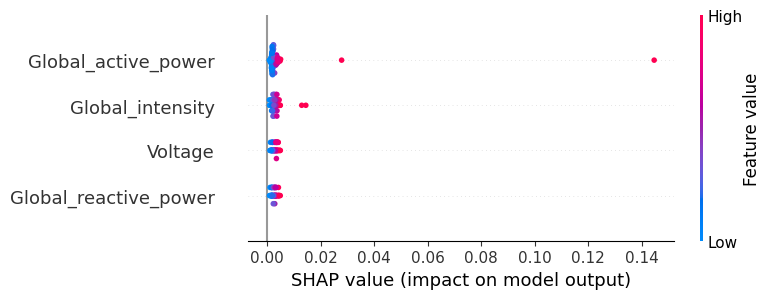

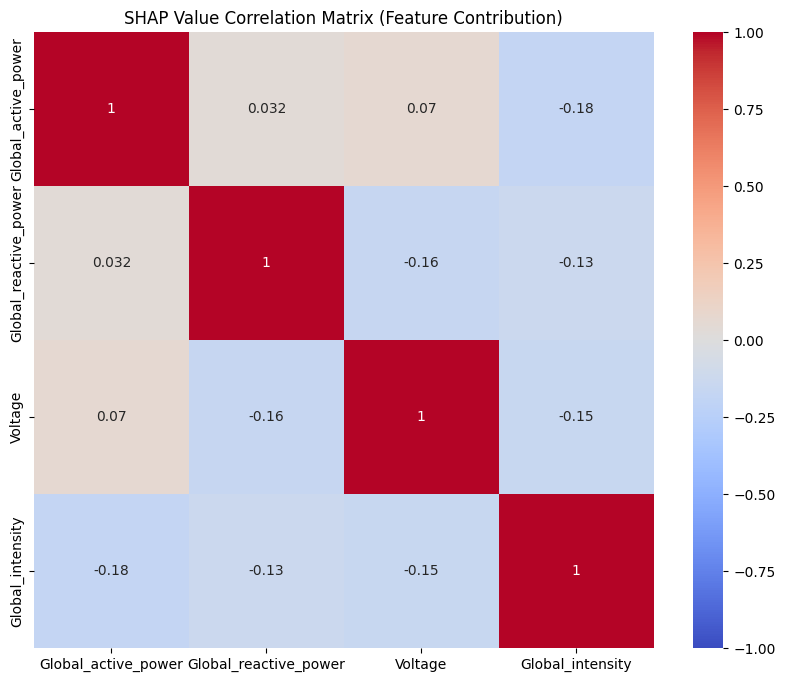

In [21]:
num_samples = 50  # 여러 샘플을 사용하여 일반화된 분석 시도
shap_values, sampled_eval_sequences = explainer.explain(eval_sequences,
                                                        num_samples=num_samples)

# 상관관계 시각화
explainer.visualize_correlation_multiple_samples(shap_values, sampled_eval_sequences)

### Attention

In [21]:
explainer_type = 'Attention' 

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, train_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, train_sequences, sequence_length, 
                              input_size, dataset.selected_features, device)

elif explainer_type == 'Attention':
    explainer = AttentionExplainer(model_attention, device, eval_sequences, 
                                   sequence_length=60, input_size=input_size, 
                                   selected_features=dataset.selected_features)
    
elif explainer_type == 'GRAD_CAM':
    explainer = GradCAMExplainer(model, device)
    
else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

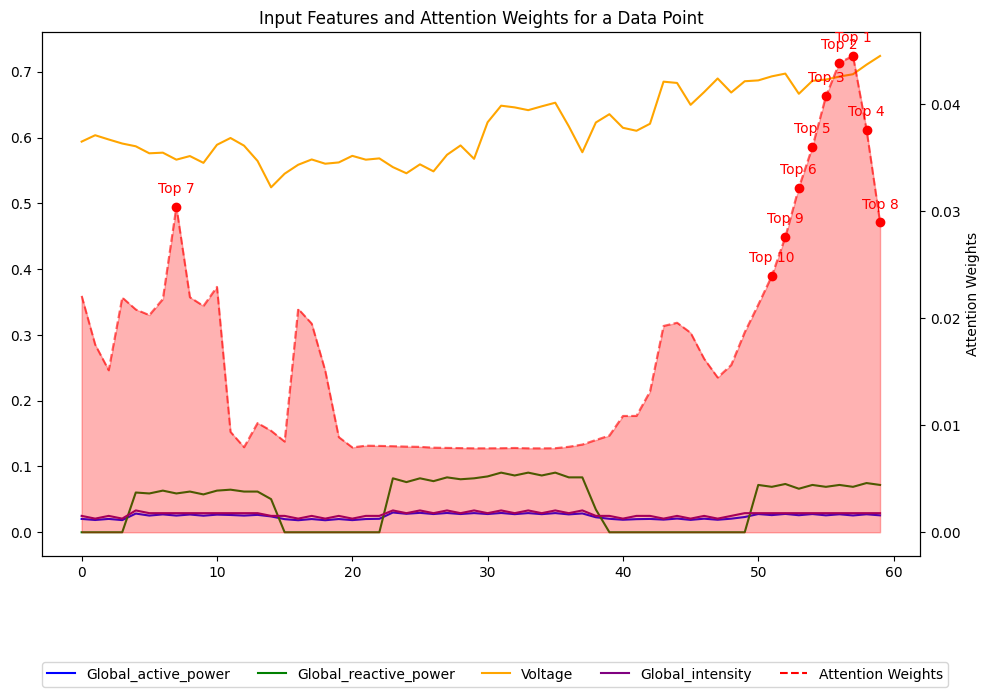

Prediction for the data point: 0.02401115745306015
Top 10 time steps with highest attention weights:
Top 1 - Time step 57: Attention Weight = 0.04447818174958229
  Global_active_power: 0.025529603476371537
  Global_reactive_power: 0.06906474820143886
  Voltage: 0.6962843295638121
  Global_intensity: 0.02904564315352698
Top 2 - Time step 56: Attention Weight = 0.0438651405274868
  Global_active_power: 0.027340213652000726
  Global_reactive_power: 0.07194244604316548
  Voltage: 0.6927302100161539
  Global_intensity: 0.02904564315352698
Top 3 - Time step 55: Attention Weight = 0.04072215408086777
  Global_active_power: 0.025710664493934457
  Global_reactive_power: 0.06906474820143886
  Voltage: 0.6882067851373179
  Global_intensity: 0.02904564315352698
Top 4 - Time step 58: Attention Weight = 0.03759745880961418
  Global_active_power: 0.027340213652000726
  Global_reactive_power: 0.0748201438848921
  Voltage: 0.7108239095315012
  Global_intensity: 0.02904564315352698
Top 5 - Time step 54:

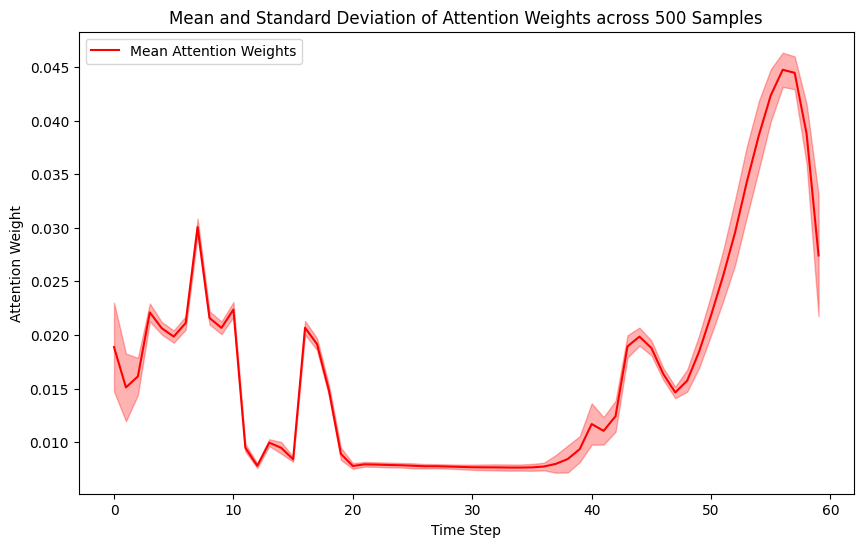

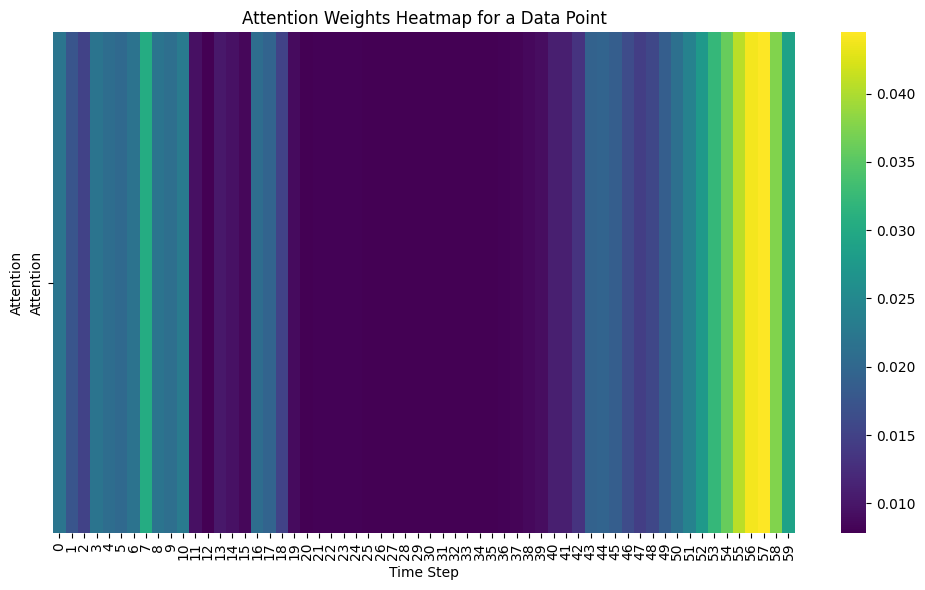

Prediction for the data point: 0.02401115745306015


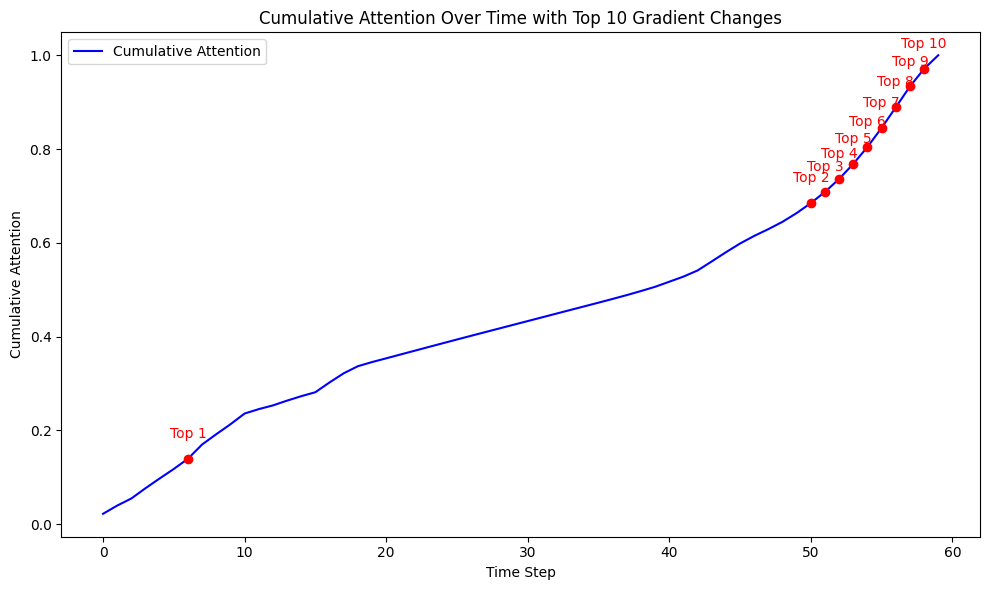

Prediction for the data point: 0.02401115745306015
Top 10 steps with largest gradient changes:
Top 1 - Time step 6: Gradient Change = 0.0217762291431427
  Global_active_power: 0.027159152634437807
  Global_reactive_power: 0.06330935251798561
  Voltage: 0.577059773828756
  Global_intensity: 0.02904564315352698
Top 2 - Time step 50: Gradient Change = 0.02125680446624756
  Global_active_power: 0.027702335687126566
  Global_reactive_power: 0.07194244604316548
  Voltage: 0.686914378029079
  Global_intensity: 0.02904564315352698
Top 3 - Time step 51: Gradient Change = 0.023931503295898438
  Global_active_power: 0.026072786529060296
  Global_reactive_power: 0.06906474820143886
  Voltage: 0.6930533117932143
  Global_intensity: 0.02904564315352698
Top 4 - Time step 52: Gradient Change = 0.027575790882110596
  Global_active_power: 0.027883396704689485
  Global_reactive_power: 0.07338129496402879
  Voltage: 0.6972536348949916
  Global_intensity: 0.02904564315352698
Top 5 - Time step 53: Gradient 

In [22]:
random_data_point = eval_sequences[np.random.choice(len(eval_sequences))]

top_n = 10

explainer.visualize_attention(random_data_point, n=top_n)

explainer.analyze_attention_distribution(num_samples=500)

explainer.visualize_attention_heatmap(random_data_point)

explainer.visualize_cumulative_attention(random_data_point, num_points=top_n)

- 추가 데이터 -> LSTM 보고, 지금처럼 결과 비슷하면(마지막 부분 가중치 높으면) 모델 구조를 바꿔보는걸로 (CNN+LSTM 기반)
- 

### Grad-CAM 

- 입력에 대한 기여도 (하나의 time step에서 featureㅂ별 기여도는 동일)

In [6]:
explainer_type = 'GRAD_CAM' 

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, train_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, train_sequences, sequence_length, 
                              input_size, dataset.selected_features, device)

elif explainer_type == 'GRAD_CAM':
    explainer = GradCAMExplainer(model, device)
    
else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

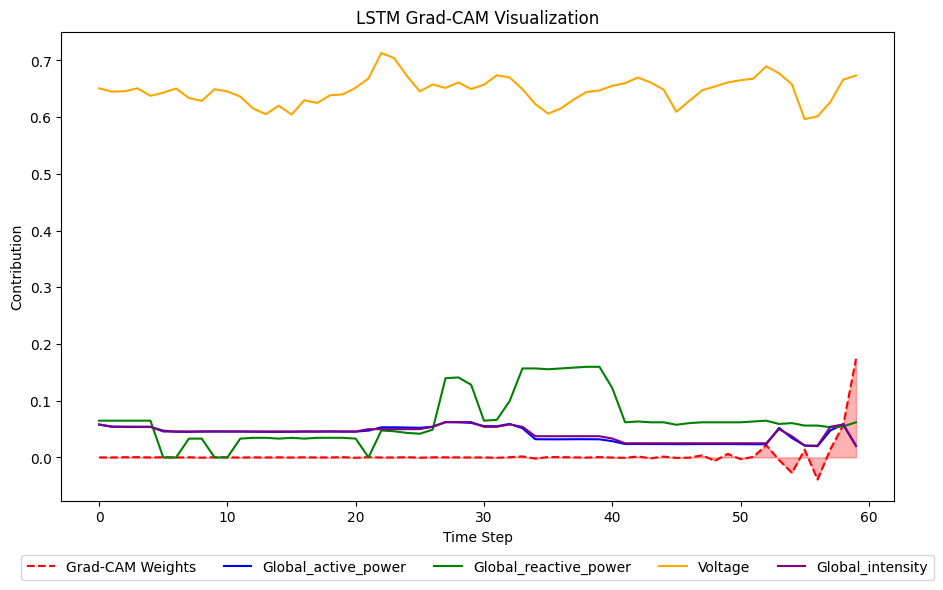

In [11]:
# 사용 예시
data_point = eval_sequences[np.random.choice(len(eval_sequences))]

grad_cam_weights = explainer.compute_grad_cam(data_point)
explainer.visualize_grad_cam(grad_cam_weights, data_point, dataset.selected_features)

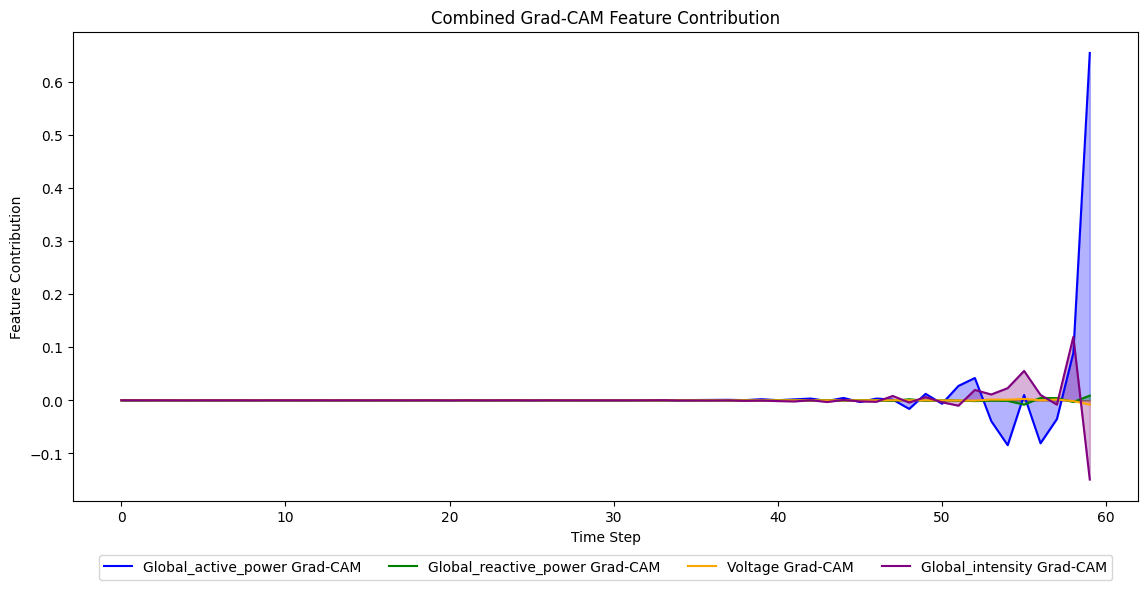

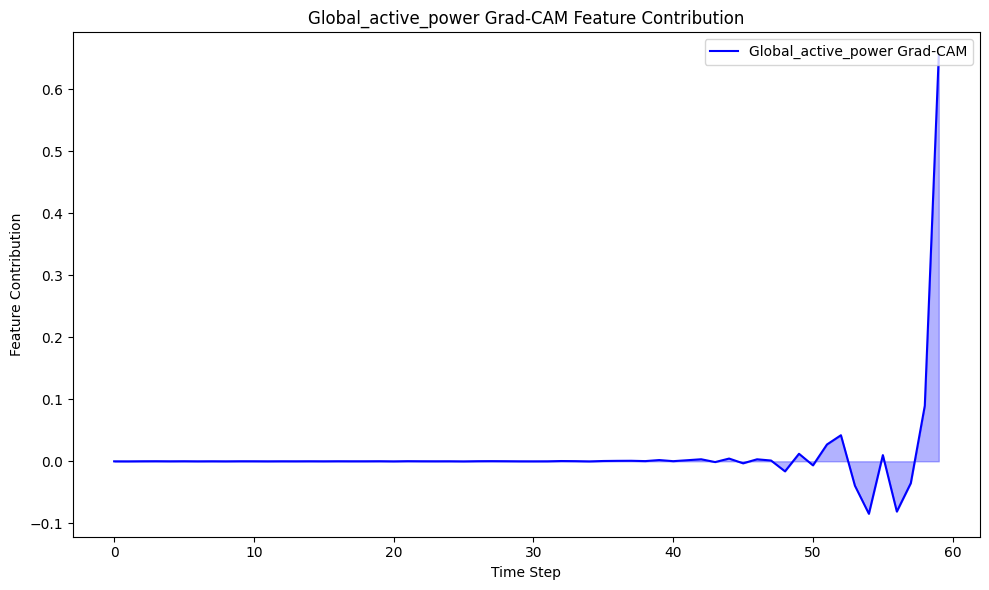

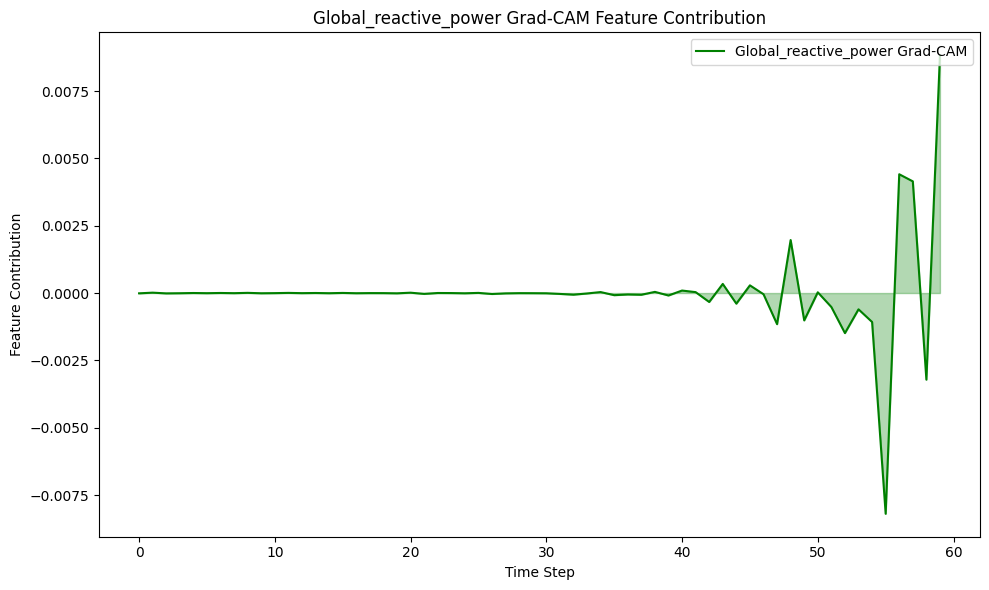

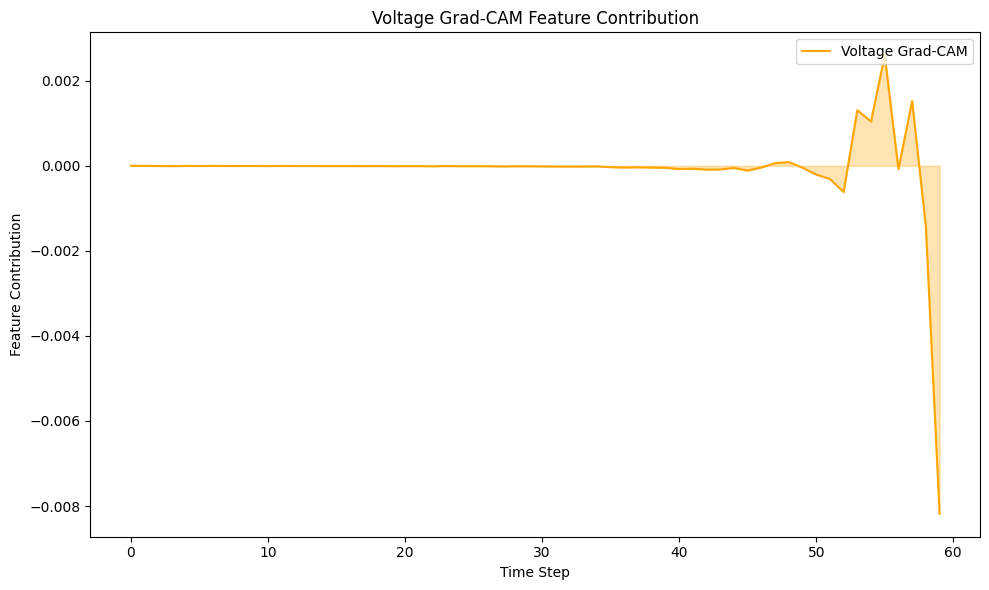

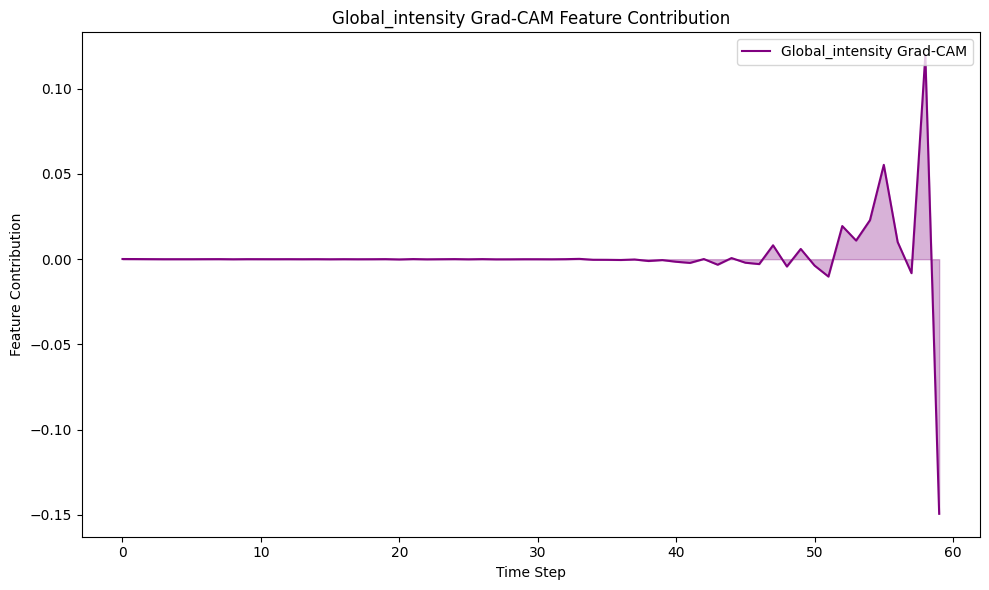

In [14]:
grad_cam_weights_per_feature = explainer.compute_grad_cam_per_feature(data_point)
explainer.visualize_grad_cam_per_feature(grad_cam_weights_per_feature, data_point, dataset.selected_features)

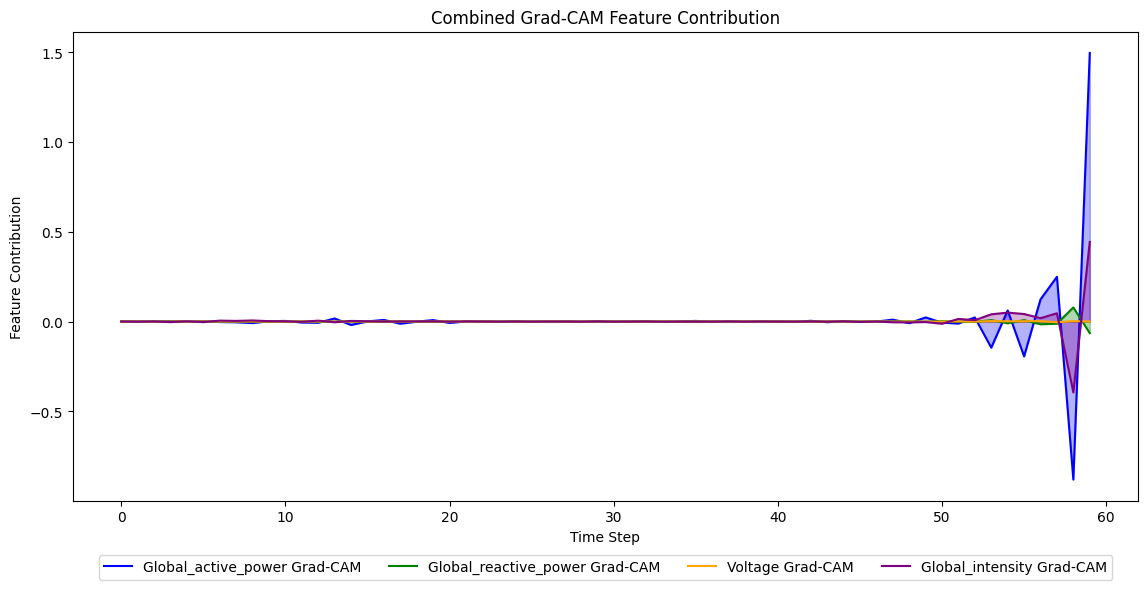

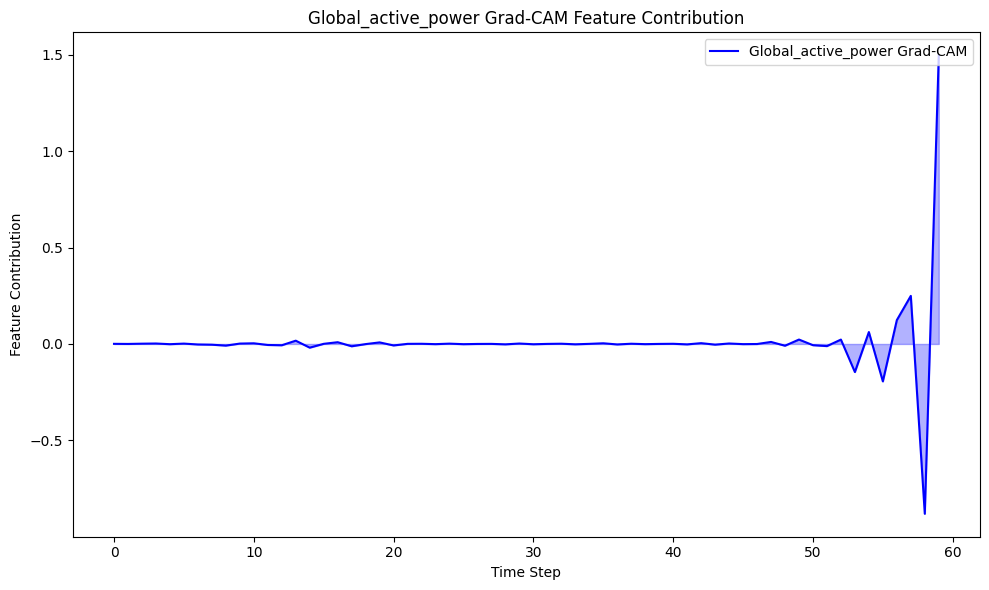

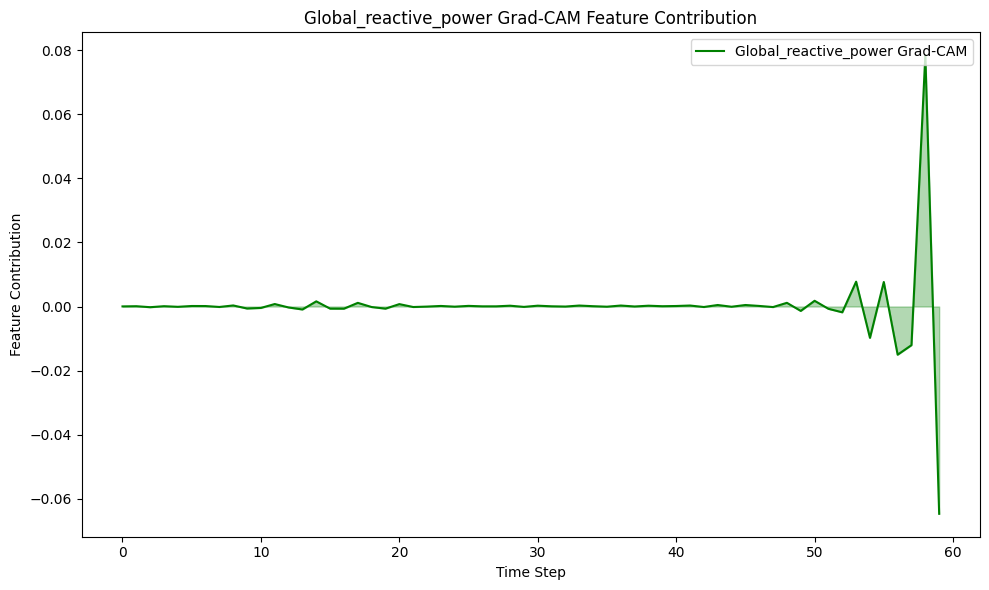

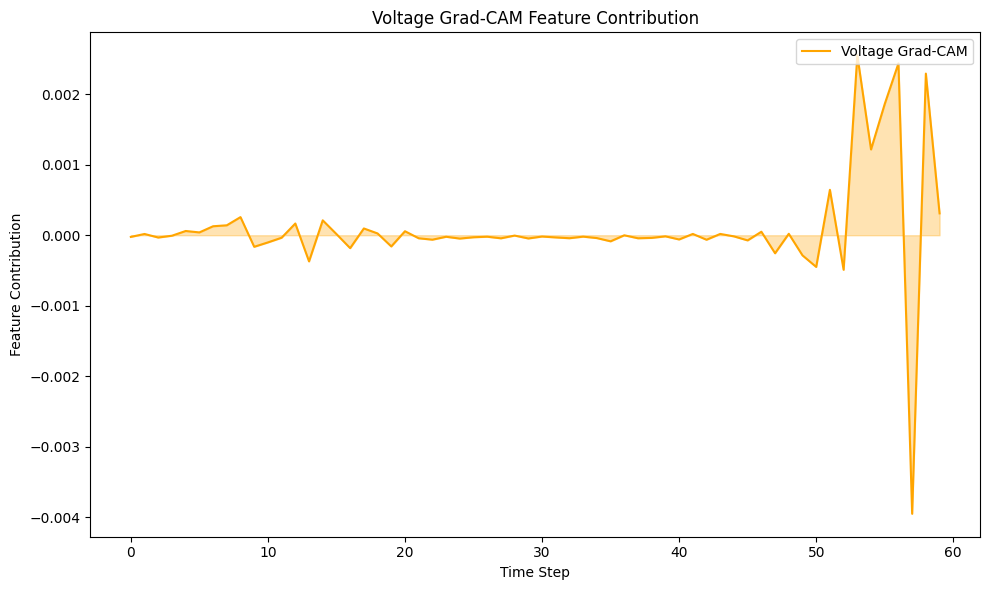

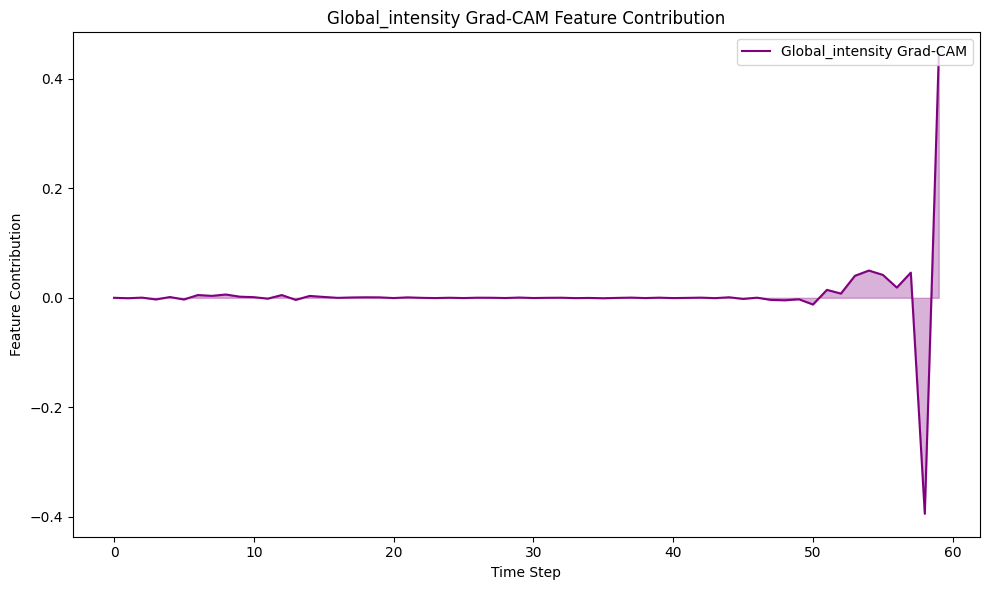

In [94]:
# 모델에 Feature별 Grad-CAM 적용
grad_cam_weights_per_feature = compute_grad_cam_lstm_per_feature(model, data_point)

# Grad-CAM 가중치 시각화 (Feature별로)
visualize_grad_cam_per_feature(grad_cam_weights_per_feature, data_point, dataset.selected_features)

### LRP (개발중)

explainer_type = 'LRP' 

if explainer_type == 'LIME':
    explainer = LimeExplainer(model, device, train_sequences, 
                              sequence_length=60, input_size=input_size, 
                              selected_features=dataset.selected_features)
elif explainer_type == 'SHAP':
    explainer = ShapExplainer(model, train_sequences, sequence_length, 
                              input_size, dataset.selected_features, device)

elif explainer_type == 'Attention':
    explainer = AttentionExplainer(model_attention, device, eval_sequences, 
                                   sequence_length=60, input_size=input_size, 
                                   selected_features=dataset.selected_features)
    
elif explainer_type == 'GRAD_CAM':
    explainer = GradCAMExplainer(model, device)

elif explainer_type == 'LRP':
    explainer = LRPExplainer(model, device, eval_sequences, sequence_length, 
                             input_size, dataset.selected_features)


else:
    raise ValueError(f"Explainer type '{explainer_type}' is not recognized.")

In [8]:
data_point = eval_sequences[np.random.choice(len(eval_sequences))]
relevance_values = explainer.explain(data_point)

# LRP 결과 시각화
explainer.visualize_lrp(relevance_values, data_point)

/archive/library/anaconda3/envs/xai_311/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


AxisError: axis 1 is out of bounds for array of dimension 1

## 앞으로 할일
- 코드 정리
- 모델 구조 추가 (CNN 기반)
- 데이터 수정(15분 단위) or 다른 데이터셋 활용
- 각 설명모듈의 시각화 결과에 대한 전문화된 설명 생성(템플릿 기반) 
- 다른 Explainer 추가 (LRP, Gradient 기반 등)
- (optional) 데이터 분포 시각화

- 날씨, 온도, 습도, 풍향 정보 등 데이터 활용해서 함께 학습 -> 기존 데이터는 하루치로 합산하여 함께 사용 (일 단위로)
- Global active power랑 Sub_metering_1
/Sub_metering_2/ Sub_metering_3 사이의 상관관계 비교 필요 -> 온도/풍향 데이터랑도 관련 있음
- 기존 <-> 추가 데이터 한것을 비교
- 